In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:

# 1. Load the dataset
df = pd.read_csv("dataset/MBA.csv")

In [3]:
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


## Exploratory data analysis

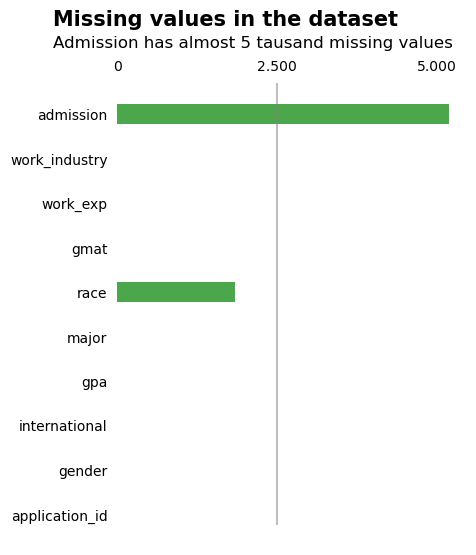

In [4]:
missing_values = df.isnull().sum()

fig, ax = plt.subplots(figsize=(4.5, 6))

ax.barh(missing_values.index, missing_values.values, height=0.45,color='green', alpha=0.7)



ax.text(x= -1000,y=11, s='Missing values in the dataset',
       size = 15, weight = 'bold')


ax.text(x=-1000,y=10.5,s='Admission has almost 5 tausand missing values',
       size= 12)

for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)
    
ax.set_xticks([0, 2500, 5000])
ax.set_xticklabels(['0','2.500','5.000'])

ax.xaxis.tick_top()
ax.tick_params(top=False, left=False)
ax.tick_params(axis='x', colors='black')
ax.axvline(x=2500, ymin=0.045, c='grey', alpha=0.5)
plt.savefig('images/missing_values.png', dpi=300, bbox_inches='tight')

plt.show()

In [5]:
# Analyzing the admission column for desbalancing
df.groupby(by='admission').count()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry
admission,,,,,,,,,
Admit,900,900,900,900,900,622,900,900,900
Waitlist,100,100,100,100,100,70,100,100,100


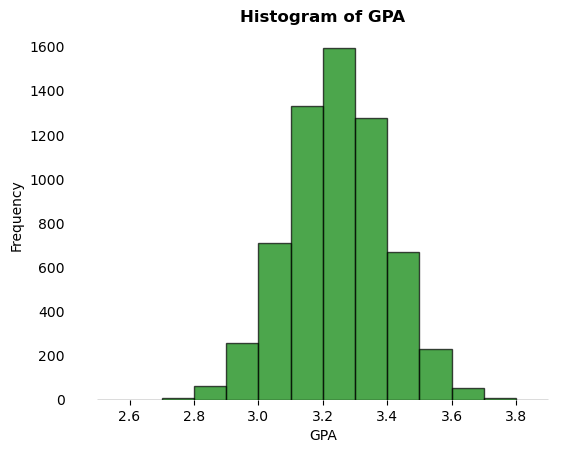

max value: 3.77
min value: 2.65
mean: 3.25
median: 3.25


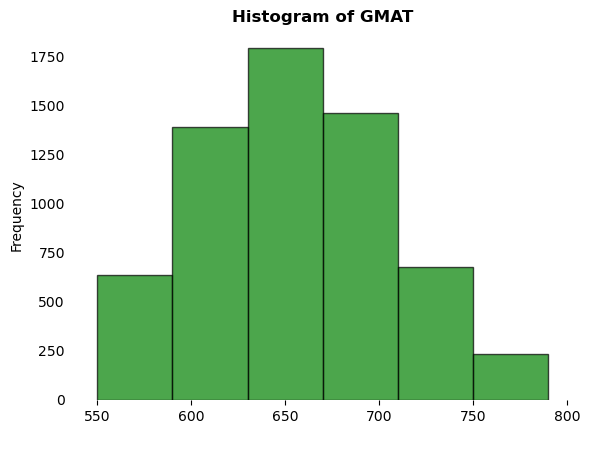

max value: 780.0
min value: 570.0
mean: 651.09
median: 650.0


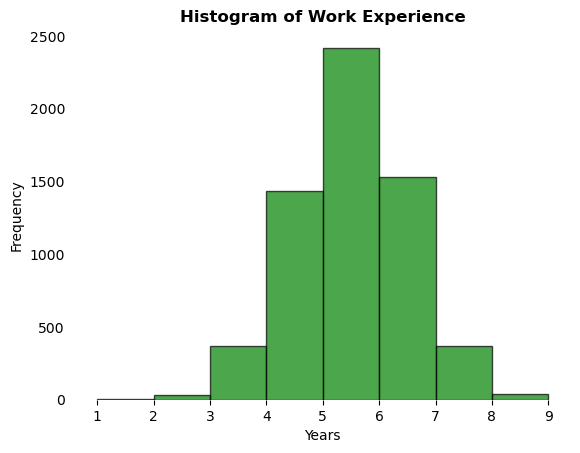

max value: 9.0
min value: 1.0
mean: 5.02
median: 5.0


In [6]:
bins_dict = {
    "gpa": np.arange(2.5, 4, 0.10),
    "gmat": np.arange(550, 800, 40),
    "work_exp": np.arange(1, 10, 1)
}

title_dict = {
    "gpa": "GPA",
    "gmat": "GMAT",
    "work_exp": "Work Experience"
}

xlabel_dict = {
    "gpa": "GPA",
    "gmat": " ",
    "work_exp": "Years"
}

for category in ["gpa", "gmat", "work_exp"]:
    fig, ax = plt.subplots()

    # Using the right bins for each category
    bins = bins_dict[category]

    ax.hist(df[category], bins=bins, color='green', alpha=0.7, edgecolor='black')

    
    for location in ['left', 'right', 'top', 'bottom']:
        ax.spines[location].set_visible(False)

    ax.tick_params(top=False, left=False)
    ax.tick_params(axis='x', colors='black')

    ax.set_title(f"Histogram of {title_dict[category]}",weight='bold')
    ax.set_xlabel(xlabel_dict[category])
    ax.set_ylabel("Frequency")
    plt.savefig(f'images/Histogram_{category}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"max value: {np.max(df[category])}")
    print(f"min value: {np.min(df[category])}")
    print(f"mean: {df[category].mean().__round__(2)}")
    print(f"median: {df[category].median()}")

In [7]:
# Analysing the gender column
df.groupby(by='gender').count()

,application_id,international,gpa,major,race,gmat,work_exp,work_industry,admission
gender,,,,,,,,,
Female,2251,2251,2251,2251,1592,2251,2251,2251,500
Male,3943,3943,3943,3943,2760,3943,3943,3943,500


## Attribute Engineering

In [8]:
df['admission'].unique()

array(['Admit', nan, 'Waitlist'], dtype=object)

In [9]:
# Organizing the 'admission' column

df.loc[df["admission"] == "Waitlist", "admission"] = "Admit"

df["admission"] = (df["admission"] == "Admit").astype(int)

df['admission'].unique()

array([1, 0])

In [10]:
# Organizing the 'race' column 

df.fillna(value={'race':  "Unknown"}, inplace=True)

In [11]:
# Map 'Female' to 0 and 'Male' to 1, then convert to integer

df["gender"] = df["gender"].map({'Female': 1, 'Male': 0}).astype(int)

In [12]:
df["race"].unique()

array(['Asian', 'Black', 'Unknown', 'Hispanic', 'White', 'Other'],
      dtype=object)

In [13]:
# Map races kinds and then convert to integer

df["race"] = df["race"].map({'Other': 0, 'Hispanic': 1,'Black':2, 'Asian':3,'White':4,'Unknown':5}).astype(int)

In [14]:
df["work_industry"].unique()

array(['Financial Services', 'Investment Management', 'Technology',
       'Consulting', 'Nonprofit/Gov', 'PE/VC', 'Health Care',
       'Investment Banking', 'Other', 'Retail', 'Energy', 'CPG',
       'Real Estate', 'Media/Entertainment'], dtype=object)

In [15]:
df["work_industry"] = df["work_industry"].map({
    'CPG': 0,
    'Consulting': 1,
    'Energy': 2,
    'Financial Services': 3,
    'Health Care': 4,
    'Investment Banking': 5,
    'Investment Management': 6,
    'Media/Entertainment': 7,
    'Nonprofit/Gov': 8,
    'Other': 9,
    'PE/VC': 10,
    'Real Estate': 11,
    'Retail': 12,
    'Technology': 13
}).astype(int)


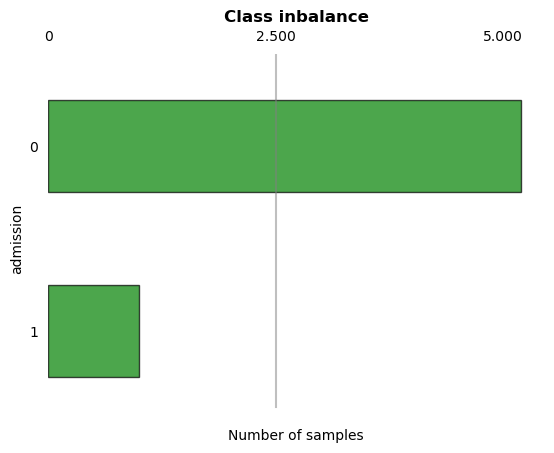

In [17]:
# Class balancing
fig, ax = plt.subplots()
df["admission"].value_counts().sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.7, edgecolor='black', ax=ax)

for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)
    
ax.set_xticks([0, 2500, 5000])
ax.set_xticklabels(['0', '2.500', '5.000'])
ax.set_title(f"Admission class imbalance",weight='bold')
ax.xaxis.tick_top()
ax.tick_params(top=False, left=False)
ax.tick_params(axis='x', colors='black')
ax.axvline(x=2500, ymin=0.045, c='grey', alpha=0.5)
plt.title("Class inbalance", weight='bold')
plt.xlabel("Number of samples")
plt.savefig('images/class_inbalance.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
# Under-sampling class 0 of the 'admission' column
df_0 = df[df["admission"] == 0].sample(n=len(df[df["admission"] == 1]), random_state=42)
df_1 = df[df["admission"] == 1]
df = pd.concat([df_0, df_1], axis=0)


## Model Implementation in Pytorch

In [19]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

## Train

In [20]:

features = ["gpa", "gmat", "work_exp", 'gender','race','work_industry']
X = df[features].values
y = df["admission"].values

In [21]:
# Spliting the dataset into training and validation sets
# 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a StandardScaler instance
sc = StandardScaler()

# Fit the scaler only on the training data
# This computes the mean and standard deviation to be used for later scaling
sc.fit(X_train)

# Transform both training and validation sets
# Scale the training data
X_train = sc.transform(X_train)

# Apply the same transformation to the validation data
X_val = sc.transform(X_val)


In [22]:
def figure1(X_train, y_train, X_val, y_val, cm_bright=None):
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)#, edgecolors='k')
    #ax[0].set_xlabel(r'$X_1$')
    #ax[0].set_ylabel(r'$X_2$')
    #ax[0].set_xlim([-2.3, 2.3])
    #ax[0].set_ylim([-2.3, 2.3])
    ax[0].set_title('Generated Data - Train')

    ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright)#, edgecolors='k')
    #ax[1].set_xlabel(r'$X_1$')
    #ax[1].set_ylabel(r'$X_2$')
    #ax[1].set_xlim([-2.3, 2.3])
    #ax[1].set_ylim([-2.3, 2.3])
    ax[1].set_title('Generated Data - Validation')
    fig.tight_layout()

    return fig

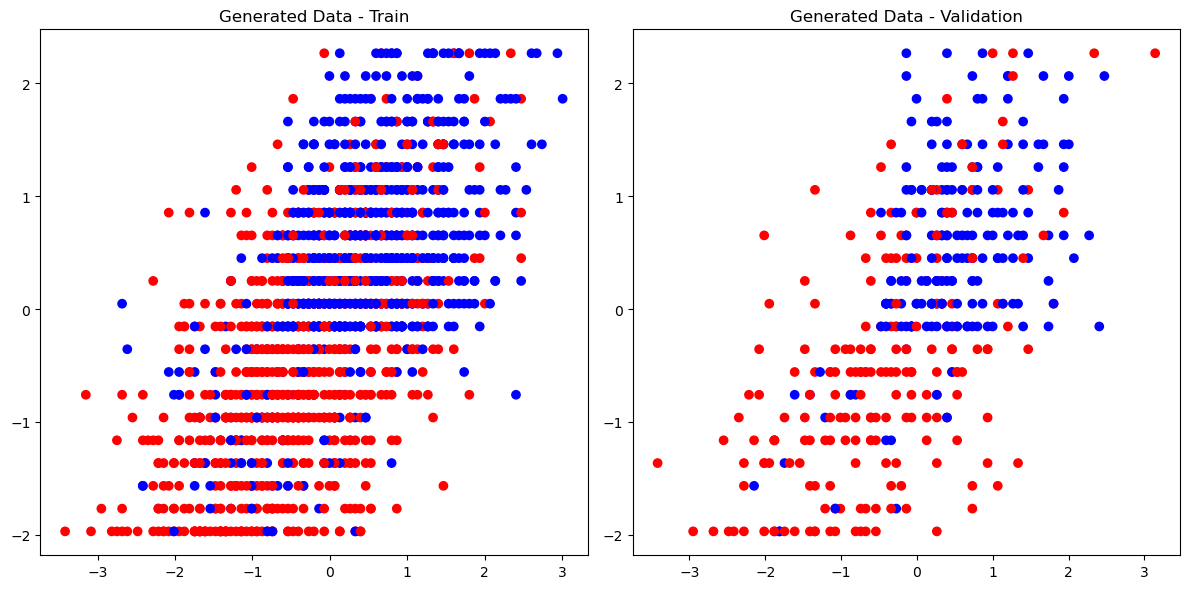

In [23]:
fig = figure1(X_train, y_train, X_val, y_val)
plt.show()

In [24]:
torch.manual_seed(42)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=16)


In [25]:
y_train_tensor.size(), y_val_tensor.size(), x_train_tensor.size(), x_val_tensor.size()

(torch.Size([1600, 1]),
 torch.Size([400, 1]),
 torch.Size([1600, 6]),
 torch.Size([400, 6]))

In [26]:

# Defines the model
lr = 0.0001

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(6, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()


In [27]:
# Trains the model

n_epochs = 200

arch = Architecture(model, loss_fn, optimizer)
arch.set_loaders(train_loader, val_loader)
arch.set_seed(42)
arch.train(n_epochs)

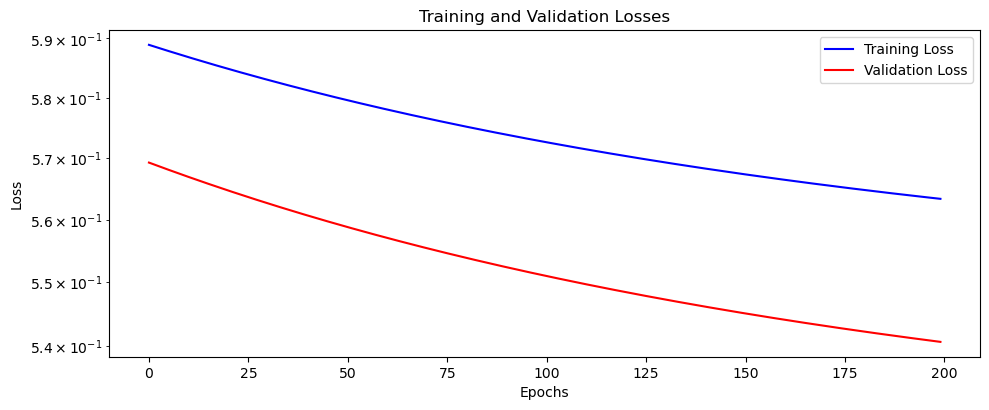

In [28]:
# Shows the training and validation losses

fig = arch.plot_losses()
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('images/train_val_loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[ 0.4233,  0.5078, -0.0753,  0.3850, -0.0320,  0.0571]],
       device='cuda:0'), 'linear.bias': tensor([-0.1304], device='cuda:0')})


In [30]:
logits_val = arch.predict(X_val[:4])
logits_val

array([[ 0.62067175],
       [ 0.6823667 ],
       [ 0.44667464],
       [-1.1592878 ]], dtype=float32)

In [31]:
# prediction probabilities
prob_val = torch.sigmoid(torch.as_tensor(logits_val[:4]).float())
prob_val

tensor([[0.6504],
        [0.6643],
        [0.6098],
        [0.2388]])

In [32]:
classes = (prob_val >= 0.5).to(torch.int8)
classes

tensor([[1],
        [1],
        [1],
        [0]], dtype=torch.int8)

In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def figure7(X, y, model, device, cm=None, cm_bright=None):
    if cm is None:
        cm = plt.cm.RdBu
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig = plt.figure(figsize=(15, 4.5))

    h = .02  # step size in the mesh

    # x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    # y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5

    x_min, x_max = -2.25, 2.25
    y_min, y_max = -2.25, 2.25

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    logits = logits.detach().cpu().numpy().reshape(xx.shape)

    yhat = sigmoid(logits)

    # 1st plot
    ax = plt.subplot(1, 3, 1)

    contour = ax.contourf(xx, yy, logits, 25, cmap=cm, alpha=.8)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$z = b + w_1x_1 + w_2x_2$')
    ax.grid(False)
    ax_c = plt.colorbar(contour)
    ax_c.set_label("$z$", rotation=0)

    # 2nd plot
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    surf = ax.plot_surface(xx, yy, yhat, rstride=1, cstride=1, alpha=.5, cmap=cm, linewidth=0, antialiased=True, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')

    ax_c = plt.colorbar(surf)
    ax_c.set_ticks([0, .25, .5, .75, 1])
    ax.view_init(30, 220)

    # 3rd plot
    ax = plt.subplot(1, 3, 3)

    ax.contour(xx, yy, yhat, levels=[.5], cmap="Greys", vmin=0, vmax=1)
    contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.8, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')
    ax.grid(False)

    ax_c = plt.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])

    plt.tight_layout()

    return fig

In [34]:
logits_val = arch.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

In [35]:
def split_cm(cm):
    # Actual negatives go in the top row,
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row,
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]

    return tn, fp, fn, tp

In [36]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

In [37]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

In [38]:

logits_val = arch.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[157,  42],
       [ 57, 144]])

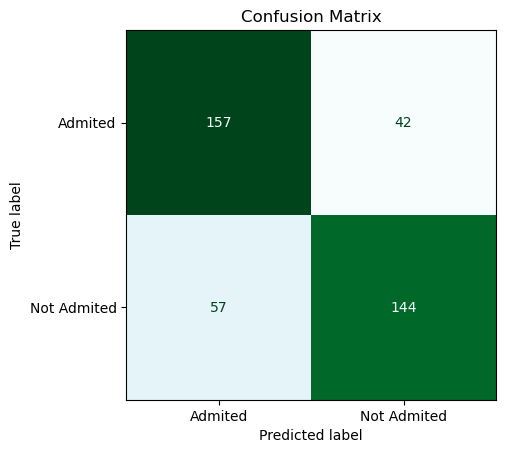

In [40]:
# Creating the confusion matrix
cm = confusion_matrix(y_val, (probabilities_val >= 0.5))

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Admited", "Not Admited"])
disp.plot(cmap=plt.cm.BuGn, colorbar=False)
plt.title("Confusion Matrix")
plt.savefig('images/CM.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
precision_recall(cm_thresh50)

(0.7741935483870968, 0.7164179104477612)

In [42]:
acc = accuracy_score(y_val, (probabilities_val >= 0.5))
acc

0.7525

## Salving the model

In [43]:
arch.save_checkpoint("model/checkpoint_model.pth")